In [1]:
import tensorflow as tf
import tensorflow.keras

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
train_df = pd.read_csv('dataset/train.csv',parse_dates = ['Datetime'],index_col='Datetime')
test_df = pd.read_csv('dataset/test.csv')
train_wd = pd.read_csv("dataset/train.csv")
sample = pd.read_csv("dataset/sample.csv")

In [4]:
train_df.head()

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2


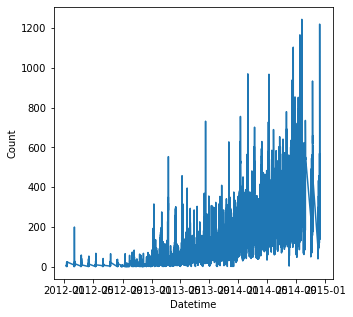

In [5]:
plt.figure(figsize=(5,5))
sns.lineplot(x=train_df.index,y=train_df['Count'],data=train_df)

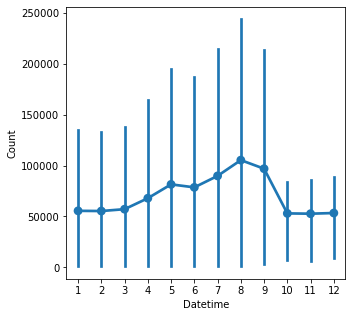

In [6]:
train_bymonth = train_df.resample("M").sum()

plt.figure(figsize=(5,5))
sns.pointplot(x=train_bymonth.index.month,y=train_bymonth['Count'],data=train_bymonth)

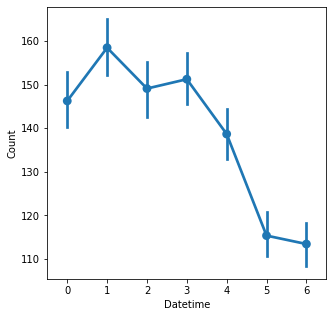

In [7]:
plt.figure(figsize=(5,5))
sns.pointplot(x=train_df.index.dayofweek,y=train_df['Count'],data=train_df)

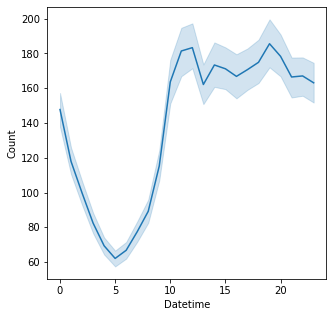

In [8]:
plt.figure(figsize=(5,5))
sns.lineplot(x=train_df.index.hour,y=train_df['Count'],data=train_df)

In [2]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [7]:
sc = StandardScaler()
train_wd['Count'] = sc.fit_transform(train_df['Count'].to_numpy().reshape(-1,1))
train_df['Count'] = sc.fit_transform(train_df['Count'].to_numpy().reshape(-1,1))

In [11]:
train_wd.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,-0.853352
1,1,25-08-2012 01:00,-0.892449
2,2,25-08-2012 02:00,-0.866384
3,3,25-08-2012 03:00,-0.892449
4,4,25-08-2012 04:00,-0.892449


In [12]:
print(len(train_df))
print(len(test_df))

18288
5112


In [ ]:
'''train_len = int(0.8*len(train_df))
val_len = len(train_df)-train_len

train = train_df[:train_len]
val = train_df[train_len:]

print(train.shape)
print(val.shape)'''

In [8]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [9]:
def create_lag_test(len_test,train_wd,lag=1):
    test_lag = pd.DataFrame()
    cols,names = [],[]
    for i in tqdm(range(lag,0,-1)):
        T_hist = train_wd['Count'].shift(i-1) #Change the column name according to the dataset
        T_hist = pd.DataFrame(T_hist)
        T_hist = T_hist.iloc[-len_test:]
        cols.append(T_hist)
        names.append('t-'+str(i))

    test_lag = pd.concat(cols,axis=1)
    test_lag.columns = names
    
    return test_lag      

In [10]:
train_wd = train_wd.drop(columns=['Datetime','ID'])

In [13]:
train_set = series_to_supervised(train_wd,n_in=2)

In [15]:
x = train_set.drop('var1(t)',axis=1)
x = x.to_numpy()
y = train_set['var1(t)'].values

In [17]:
test_set = create_lag_test(len(test_df),train_wd,lag=2).to_numpy()

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1194.79it/s]


In [23]:
test_set = np.reshape(test_set,(test_set.shape[0],1,test_set.shape[1]))              

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Bidirectional,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras

In [28]:
def create_model():
    model=  Sequential()
    model.add(Bidirectional(LSTM(64,input_shape=(x.shape[1],x.shape[2]),return_sequences=True)))
    model.add(Bidirectional(LSTM(8)))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    
    return model    

In [29]:
model = create_model()
model.compile(loss='mse',optimizer='adam')

In [30]:
callback = [EarlyStopping(patience=5,
                         monitor='val_loss'),
           PlotLossesKeras()]

Using TensorFlow backend.


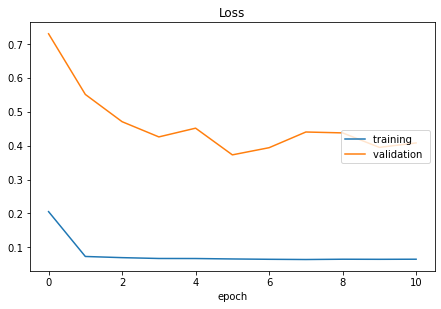

Loss
	training         	 (min:    0.064, max:    0.205, cur:    0.065)
	validation       	 (min:    0.373, max:    0.730, cur:    0.408)
16457/16457 [==============================] - 2s 145us/sample - loss: 0.0651 - val_loss: 0.4079


In [34]:
h = model.fit(x,y,
             validation_split=0.1,
             epochs=35,
             batch_size=128,
             callbacks=callback)

In [35]:
y_pred = model.predict(test_set)
y_pred = sc.inverse_transform(y_pred)
y_pred = np.squeeze(y_pred)

In [40]:
sub = pd.DataFrame({"ID":test_df.ID,'Count':y_pred})

In [41]:
sub.to_csv("Submission.csv",index=False)